In [1]:
!git clone https://github.com/minhhien0111/CLIP_prefiz_caption.git
%cd CLIP_prefiz_caption

Cloning into 'CLIP_prefiz_caption'...
remote: Enumerating objects: 179, done.
remote: Counting objects: 100% (179/179), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 179 (delta 90), reused 176 (delta 87), pack-reused 0 (from 0)
Receiving objects: 100% (179/179), 2.18 MiB | 2.20 MiB/s, done.
Resolving deltas: 100% (90/90), done.
/kaggle/working/CLIP_prefiz_caption


In [2]:
!pip install git+https://github.com/openai/CLIP.git
!pip install --upgrade setuptools packaging
!pip install transformers

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-5453koo6
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-5453koo6
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.6 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=c47aca6c1b2fe66d6b0f999e19ca24990178fa15a014f1ec62427567eb2e97bd
  Stored in directory: /tmp/pip-ephem-wheel-cache-1zty3wyv/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.7 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 70.0.0
    Uninstalling setuptools-70.0.0:
      Su

In [3]:
!python parse_coco.py --clip_model_type ViT-B/32

100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 106MiB/s]
30000 captions loaded from json 
100%|█████████████████████████████████████| 30000/30000 [08:32<00:00, 58.50it/s]
Done
30000 embeddings saved 


In [4]:
!python train.py --data /kaggle/working/oscar_split_ViT-B_32_train.pkl --out_dir /kaggle/working/ --epochs 15

tokenizer_config.json: 100%|██████████████████| 26.0/26.0 [00:00<00:00, 201kB/s]
vocab.json: 100%|██████████████████████████| 1.04M/1.04M [00:00<00:00, 7.99MB/s]
merges.txt: 100%|████████████████████████████| 456k/456k [00:00<00:00, 51.9MB/s]
tokenizer.json: 100%|██████████████████████| 1.36M/1.36M [00:00<00:00, 37.0MB/s]
config.json: 100%|█████████████████████████████| 665/665 [00:00<00:00, 5.53MB/s]
/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer b

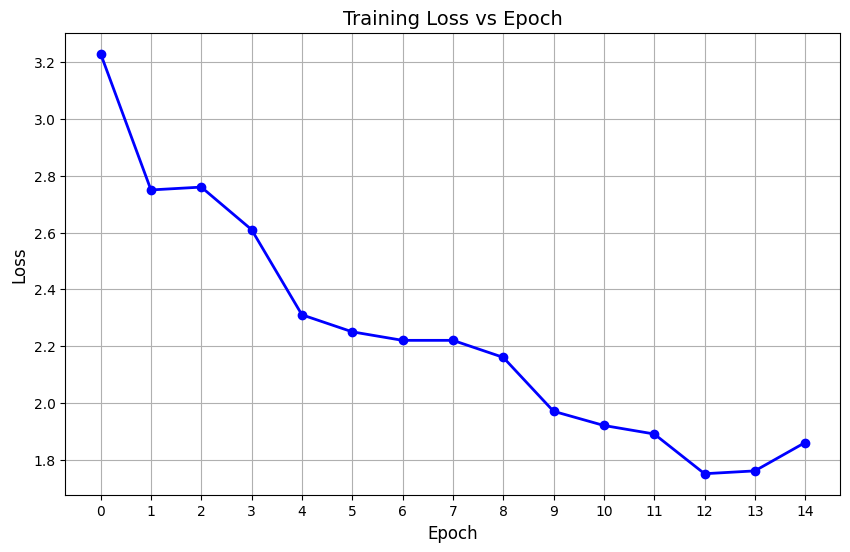

In [1]:
import matplotlib.pyplot as plt

# Epochs and corresponding loss values from the log
epochs = list(range(15))
loss = [3.23, 2.75, 2.76, 2.61, 2.31, 2.25, 2.22, 2.22, 2.16, 1.97, 1.92, 1.89, 1.75, 1.76, 1.86]

# Plotting the graph
plt.figure(figsize=(10,6))
plt.plot(epochs, loss, marker='o', color='b', linestyle='-', linewidth=2, markersize=6)
plt.title("Training Loss vs Epoch", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True)
plt.xticks(epochs)
plt.show()

In [16]:
#@title Imports

import clip
import os
from torch import nn
import numpy as np
import torch
import torch.nn.functional as nnf
import sys
from typing import Tuple, List, Union, Optional
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import skimage.io as io
import PIL.Image
from IPython.display import Image 


N = type(None)
V = np.array
ARRAY = np.ndarray
ARRAYS = Union[Tuple[ARRAY, ...], List[ARRAY]]
VS = Union[Tuple[V, ...], List[V]]
VN = Union[V, N]
VNS = Union[VS, N]
T = torch.Tensor
TS = Union[Tuple[T, ...], List[T]]
TN = Optional[T]
TNS = Union[Tuple[TN, ...], List[TN]]
TSN = Optional[TS]
TA = Union[T, ARRAY]


D = torch.device
CPU = torch.device('cpu')


def get_device(device_id: int) -> D:
    if not torch.cuda.is_available():
        return CPU
    device_id = min(torch.cuda.device_count() - 1, device_id)
    return torch.device(f'cuda:{device_id}')


CUDA = get_device
# model_path = "/kaggle/working/"

In [5]:
#@title Model

class MLP(nn.Module):

    def forward(self, x: T) -> T:
        return self.model(x)

    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) -1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)


class ClipCaptionModel(nn.Module):

    #@functools.lru_cache #FIXME
    def get_dummy_token(self, batch_size: int, device: D) -> T:
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    def forward(self, tokens: T, prefix: T, mask: Optional[T] = None, labels: Optional[T] = None):
        embedding_text = self.gpt.transformer.wte(tokens)
        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.gpt_embedding_size)
        #print(embedding_text.size()) #torch.Size([5, 67, 768])
        #print(prefix_projections.size()) #torch.Size([5, 1, 768])
        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out

    def __init__(self, prefix_length: int, prefix_size: int = 512):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length
        self.gpt = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        if prefix_length > 10:  # not enough memory
            self.clip_project = nn.Linear(prefix_size, self.gpt_embedding_size * prefix_length)
        else:
            self.clip_project = MLP((prefix_size, (self.gpt_embedding_size * prefix_length) // 2, self.gpt_embedding_size * prefix_length))


class ClipCaptionPrefix(ClipCaptionModel):

    def parameters(self, recurse: bool = True):
        return self.clip_project.parameters()

    def train(self, mode: bool = True):
        super(ClipCaptionPrefix, self).train(mode)
        self.gpt.eval()
        return self

In [13]:
#@title Caption prediction

def generate_beam(model, tokenizer, beam_size: int = 5, prompt=None, embed=None,
                  entry_length=67, temperature=1., stop_token: str = '.'):

    model.eval()
    stop_token_index = tokenizer.encode(stop_token)[0]
    tokens = None
    scores = None
    device = next(model.parameters()).device
    seq_lengths = torch.ones(beam_size, device=device)
    is_stopped = torch.zeros(beam_size, device=device, dtype=torch.bool)
    with torch.no_grad():
        if embed is not None:
            generated = embed
        else:
            if tokens is None:
                tokens = torch.tensor(tokenizer.encode(prompt))
                tokens = tokens.unsqueeze(0).to(device)
                generated = model.gpt.transformer.wte(tokens)
        for i in range(entry_length):
            outputs = model.gpt(inputs_embeds=generated)
            logits = outputs.logits
            logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
            logits = logits.softmax(-1).log()
            if scores is None:
                scores, next_tokens = logits.topk(beam_size, -1)
                generated = generated.expand(beam_size, *generated.shape[1:])
                next_tokens, scores = next_tokens.permute(1, 0), scores.squeeze(0)
                if tokens is None:
                    tokens = next_tokens
                else:
                    tokens = tokens.expand(beam_size, *tokens.shape[1:])
                    tokens = torch.cat((tokens, next_tokens), dim=1)
            else:
                logits[is_stopped] = -float(np.inf)
                logits[is_stopped, 0] = 0
                scores_sum = scores[:, None] + logits
                seq_lengths[~is_stopped] += 1
                scores_sum_average = scores_sum / seq_lengths[:, None]
                scores_sum_average, next_tokens = scores_sum_average.view(-1).topk(beam_size, -1)
                next_tokens_source = next_tokens // scores_sum.shape[1]
                seq_lengths = seq_lengths[next_tokens_source]
                next_tokens = next_tokens % scores_sum.shape[1]
                next_tokens = next_tokens.unsqueeze(1)
                tokens = tokens[next_tokens_source]
                tokens = torch.cat((tokens, next_tokens), dim=1)
                generated = generated[next_tokens_source]
                scores = scores_sum_average * seq_lengths
                is_stopped = is_stopped[next_tokens_source]
            next_token_embed = model.gpt.transformer.wte(next_tokens.squeeze()).view(generated.shape[0], 1, -1)
            generated = torch.cat((generated, next_token_embed), dim=1)
            is_stopped = is_stopped + next_tokens.eq(stop_token_index).squeeze()
            if is_stopped.all():
                break
    scores = scores / seq_lengths
    output_list = tokens.cpu().numpy()
    output_texts = [tokenizer.decode(output[:int(length)]) for output, length in zip(output_list, seq_lengths)]
    order = scores.argsort(descending=True)
    output_texts = [output_texts[i] for i in order]
    return output_texts


def generate2(
        model,
        tokenizer,
        tokens=None,
        prompt=None,
        embed=None,
        entry_count=1,
        entry_length=67,  # maximum number of words
        top_p=0.8,
        temperature=1.,
        stop_token: str = '.',
):
    model.eval()
    generated_num = 0
    generated_list = []
    stop_token_index = tokenizer.encode(stop_token)[0]
    filter_value = -float("Inf")
    device = next(model.parameters()).device

    with torch.no_grad():

        for entry_idx in trange(entry_count):
            if embed is not None:
                generated = embed
            else:
                if tokens is None:
                    tokens = torch.tensor(tokenizer.encode(prompt))
                    tokens = tokens.unsqueeze(0).to(device)

                generated = model.gpt.transformer.wte(tokens)

            for i in range(entry_length):

                outputs = model.gpt(inputs_embeds=generated)
                logits = outputs.logits
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(nnf.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                                                    ..., :-1
                                                    ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value
                next_token = torch.argmax(logits, -1).unsqueeze(0)
                next_token_embed = model.gpt.transformer.wte(next_token)
                if tokens is None:
                    tokens = next_token
                else:
                    tokens = torch.cat((tokens, next_token), dim=1)
                generated = torch.cat((generated, next_token_embed), dim=1)
                if stop_token_index == next_token.item():
                    break

            output_list = list(tokens.squeeze().cpu().numpy())
            output_text = tokenizer.decode(output_list)
            generated_list.append(output_text)

    return generated_list[0]

In [9]:
is_gpu = True #@param {type:"boolean"}
device = CUDA(0) if is_gpu else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [10]:
prefix_length = 10

model = ClipCaptionModel(prefix_length)

model.load_state_dict(torch.load("/kaggle/input/checkpoint_gpt2_15epochs/pytorch/default/1/coco_prefix-014.pt", map_location=CPU)) 

model = model.eval() 
device = CUDA(0) if is_gpu else "cpu"
model = model.to(device)

/tmp/ipykernel_23/2915799766.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/input/checkpoint_gpt2_15epochs/pytorch/default/1/c

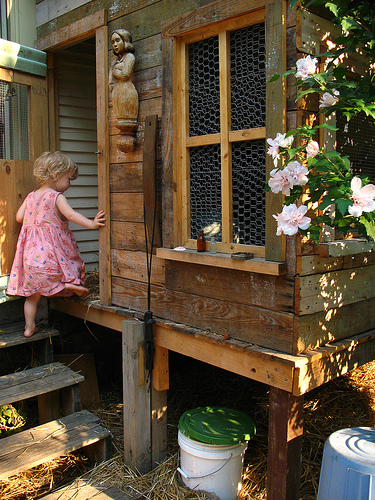



A little girl in a pink dress climbing into a wooden playhouse


In [17]:
#@title Inference
import re
use_beam_search = True #@param {type:"boolean"}  

image = io.imread("/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg")
pil_image = PIL.Image.fromarray(image)
#pil_img = Image(filename=UPLOADED_FILE)
display(pil_image)

image = preprocess(pil_image).unsqueeze(0).to(device)
with torch.no_grad():
    # if type(model) is ClipCaptionE2E:
    #     prefix_embed = model.forward_image(image)
    # else:
    prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
    prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
if use_beam_search:
    generated_text_prefix = generate_beam(model, tokenizer, embed=prefix_embed)[0]
else:
    generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)


print('\n')
generated_text_prefix = re.sub(r"\.+", "", generated_text_prefix).strip()
generated_text_prefix = generated_text_prefix.split("  ")[0]
print(generated_text_prefix)
# hypo = []
# ref = []
# temp = "A little boy is jumping into a pool while another child watches"
# hypo.append(generated_text_prefix.split())
# ref.append(temp.split())
# corpus_bleu(ref, hypo, weights=(1, 0, 0, 0))

In [17]:
import json
import torch.nn as nn
import re
use_beam_search = True #@param {type:"boolean"}
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

hypotheses = []
references = []

with open('/kaggle/input/train-val-test-data/test_data.json', 'r') as f:
        test_data = json.load(f)

for i in tqdm(range(len(test_data))):
    d = test_data[i]
    image = io.imread(f"/kaggle/input/flickr8k/Images/{d['image_id']}")
    pil_image = PIL.Image.fromarray(image)
    
    image = preprocess(pil_image).unsqueeze(0).to(device)
    with torch.no_grad():
        prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
        prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
    if use_beam_search:
        generated_text_prefix = generate_beam(model,beam_size = 7, tokenizer = tokenizer, embed=prefix_embed)[0]
    else:
        generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)
    generated_text_prefix = re.sub(r"\.+", "", generated_text_prefix).strip()
    generated_text_prefix = generated_text_prefix.split("  ")[0]
    hypotheses.append(generated_text_prefix.split())
    references.append(d["caption"])

100%|██████████| 1000/1000 [36:20<00:00,  2.18s/it]


In [19]:
# # Calculate BLEU scores from 1-gram to 4-gram
# smooth_fn = SmoothingFunction().method1
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
# smoothie = SmoothingFunction().method4

# Compute BLEU-1 to BLEU-4
bleu_1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0))
bleu_2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
bleu_3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
bleu_4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))
print("\nBLEU-1 score @ beam size of %d is %.4f." % (1, bleu_1))
print("\nBLEU-2 score @ beam size of %d is %.4f." % (1, bleu_2))
print("\nBLEU-3 score @ beam size of %d is %.4f." % (1, bleu_3))
print("\nBLEU-4 score @ beam size of %d is %.4f." % (1, bleu_4))


BLEU-1 score @ beam size of 1 is 0.5111.

BLEU-2 score @ beam size of 1 is 0.3651.

BLEU-3 score @ beam size of 1 is 0.2569.

BLEU-4 score @ beam size of 1 is 0.1718.


In [21]:
# # Calculate BLEU scores from 1-gram to 4-gram
# smooth_fn = SmoothingFunction().method1
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
# smoothie = SmoothingFunction().method4

# Compute BLEU-1 to BLEU-4
bleu_1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0))
bleu_2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
bleu_3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
bleu_4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))
print("\nBLEU-1 score @ beam size of %d is %.4f." % (3, bleu_1))
print("\nBLEU-2 score @ beam size of %d is %.4f." % (3, bleu_2))
print("\nBLEU-3 score @ beam size of %d is %.4f." % (3, bleu_3))
print("\nBLEU-4 score @ beam size of %d is %.4f." % (3, bleu_4))


BLEU-1 score @ beam size of 3 is 0.5662.

BLEU-2 score @ beam size of 3 is 0.4067.

BLEU-3 score @ beam size of 3 is 0.2923.

BLEU-4 score @ beam size of 3 is 0.2016.


In [48]:
# # Calculate BLEU scores from 1-gram to 4-gram
# smooth_fn = SmoothingFunction().method1
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
# smoothie = SmoothingFunction().method4

# Compute BLEU-1 to BLEU-4
bleu_1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0))
bleu_2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
bleu_3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
bleu_4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))
print("\nBLEU-1 score @ beam size of %d is %.4f." % (5, bleu_1))
print("\nBLEU-2 score @ beam size of %d is %.4f." % (5, bleu_2))
print("\nBLEU-3 score @ beam size of %d is %.4f." % (5, bleu_3))
print("\nBLEU-4 score @ beam size of %d is %.4f." % (5, bleu_4))


BLEU-1 score @ beam size of 5 is 0.5459.

BLEU-2 score @ beam size of 5 is 0.3918.

BLEU-3 score @ beam size of 5 is 0.2811.

BLEU-4 score @ beam size of 5 is 0.1929.


In [23]:
# # Calculate BLEU scores from 1-gram to 4-gram
# smooth_fn = SmoothingFunction().method1
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
# smoothie = SmoothingFunction().method4

# Compute BLEU-1 to BLEU-4
bleu_1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0))
bleu_2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
bleu_3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
bleu_4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))
print("\nBLEU-1 score @ beam size of %d is %.4f." % (7, bleu_1))
print("\nBLEU-2 score @ beam size of %d is %.4f." % (7, bleu_2))
print("\nBLEU-3 score @ beam size of %d is %.4f." % (7, bleu_3))
print("\nBLEU-4 score @ beam size of %d is %.4f." % (7, bleu_4))


BLEU-1 score @ beam size of 7 is 0.5539.

BLEU-2 score @ beam size of 7 is 0.3964.

BLEU-3 score @ beam size of 7 is 0.2837.

BLEU-4 score @ beam size of 7 is 0.1946.


In [11]:
# # Calculate BLEU scores from 1-gram to 4-gram
# smooth_fn = SmoothingFunction().method1
# epoch = 15
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
# smoothie = SmoothingFunction().method4

# Compute BLEU-1 to BLEU-4
bleu_1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0))
bleu_2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
bleu_3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
bleu_4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))
print("\nBLEU-1 score @ beam size of %d is %.4f." % (3, bleu_1))
print("\nBLEU-2 score @ beam size of %d is %.4f." % (3, bleu_2))
print("\nBLEU-3 score @ beam size of %d is %.4f." % (3, bleu_3))
print("\nBLEU-4 score @ beam size of %d is %.4f." % (3, bleu_4))


BLEU-1 score @ beam size of 3 is 0.6437.

BLEU-2 score @ beam size of 3 is 0.4680.

BLEU-3 score @ beam size of 3 is 0.3370.

BLEU-4 score @ beam size of 3 is 0.2348.


In [14]:
# # Calculate BLEU scores from 1-gram to 4-gram
# smooth_fn = SmoothingFunction().method1
# epoch = 15
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
# smoothie = SmoothingFunction().method4

# Compute BLEU-1 to BLEU-4
bleu_1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0))
bleu_2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
bleu_3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
bleu_4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))
print("\nBLEU-1 score @ beam size of %d is %.4f." % (5, bleu_1))
print("\nBLEU-2 score @ beam size of %d is %.4f." % (5, bleu_2))
print("\nBLEU-3 score @ beam size of %d is %.4f." % (5, bleu_3))
print("\nBLEU-4 score @ beam size of %d is %.4f." % (5, bleu_4))


BLEU-1 score @ beam size of 5 is 0.6382.

BLEU-2 score @ beam size of 5 is 0.4634.

BLEU-3 score @ beam size of 5 is 0.3332.

BLEU-4 score @ beam size of 5 is 0.2313.


In [16]:
# # Calculate BLEU scores from 1-gram to 4-gram
# smooth_fn = SmoothingFunction().method1
# epoch = 15
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
# smoothie = SmoothingFunction().method4

# Compute BLEU-1 to BLEU-4
bleu_1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0))
bleu_2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
bleu_3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
bleu_4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))
print("\nBLEU-1 score @ beam size of %d is %.4f." % (1, bleu_1))
print("\nBLEU-2 score @ beam size of %d is %.4f." % (1, bleu_2))
print("\nBLEU-3 score @ beam size of %d is %.4f." % (1, bleu_3))
print("\nBLEU-4 score @ beam size of %d is %.4f." % (1, bleu_4))


BLEU-1 score @ beam size of 1 is 0.6381.

BLEU-2 score @ beam size of 1 is 0.4617.

BLEU-3 score @ beam size of 1 is 0.3246.

BLEU-4 score @ beam size of 1 is 0.2197.


In [18]:
# # Calculate BLEU scores from 1-gram to 4-gram
# smooth_fn = SmoothingFunction().method1
# epoch = 15
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
# smoothie = SmoothingFunction().method4

# Compute BLEU-1 to BLEU-4
bleu_1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0))
bleu_2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
bleu_3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
bleu_4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))
print("\nBLEU-1 score @ beam size of %d is %.4f." % (7, bleu_1))
print("\nBLEU-2 score @ beam size of %d is %.4f." % (7, bleu_2))
print("\nBLEU-3 score @ beam size of %d is %.4f." % (7, bleu_3))
print("\nBLEU-4 score @ beam size of %d is %.4f." % (7, bleu_4))


BLEU-1 score @ beam size of 7 is 0.6335.

BLEU-2 score @ beam size of 7 is 0.4609.

BLEU-3 score @ beam size of 7 is 0.3316.

BLEU-4 score @ beam size of 7 is 0.2298.


In [12]:
from IPython.display import FileLink
%cd /kaggle/working
FileLink(r'coco_prefix-014.pt')

/kaggle/working


/kaggle/working/coco_prefix-014.pt

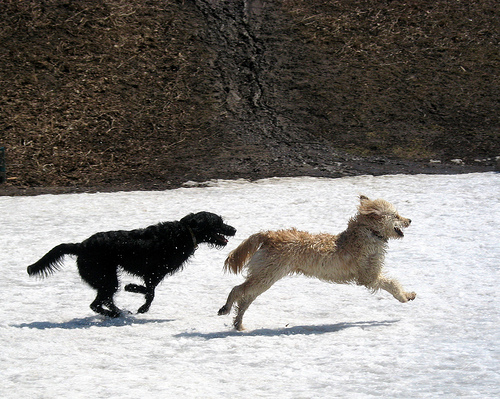

In [2]:
import skimage.io as io
import PIL.Image
from IPython.display import Image 
image = io.imread("/kaggle/input/flickr8k/Images/2513260012_03d33305cf.jpg")
pil_image = PIL.Image.fromarray(image)
#pil_img = Image(filename=UPLOADED_FILE)
display(pil_image)

In [24]:
# Import necessary libraries
import io
import torch
import PIL.Image
import ipywidgets as widgets
from IPython.display import display
from skimage import io as skio  # Avoid name conflict
import re

# File upload widget
upload_widget = widgets.FileUpload(accept='image/*', multiple=False)
display(upload_widget)

FileUpload(value=(), accept='image/*', description='Upload')

In [19]:
upload_widget.value
# img = PIL.Image.open(io.BytesIO(image_upload))

({'name': '109738763_90541ef30d.jpg',
  'type': 'image/jpeg',
  'size': 189532,
  'content': <memory at 0x7e4962e15000>,
  'last_modified': datetime.datetime(2024, 12, 9, 14, 3, 38, 149000, tzinfo=datetime.timezone.utc)},)

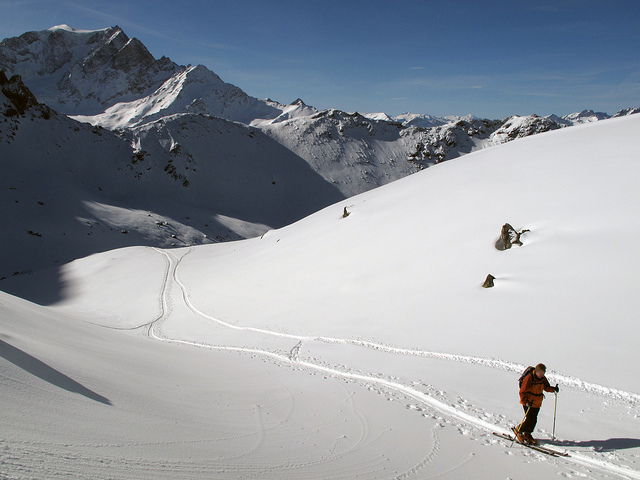

Running Inference...

Generated Caption:
A skier is skiing down a snowy hill


In [25]:
# Function to handle uploaded file
def handle_image_upload():
    if not upload_widget.value:
        print("No image uploaded!")
        return
    
    # Access the uploaded image
    uploaded_file = list(upload_widget.value)[0]
    image_bytes = uploaded_file['content']
    # pil_image = PIL.Image.open(image_bytes)
    pil_image = PIL.Image.open(io.BytesIO(image_bytes))
    display(pil_image)

    try:
        # Preprocess the image
        image = preprocess(pil_image).unsqueeze(0).to(device)

        # Model inference
        print("Running Inference...")
        with torch.no_grad():
            prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
            prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)

        if use_beam_search:
            generated_text_prefix = generate_beam(model, tokenizer, embed=prefix_embed)[0]
        else:
            generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)

        # Clean and display the generated caption
        print('\nGenerated Caption:')
        generated_text_prefix = re.sub(r"\.+", "", generated_text_prefix).strip()
        generated_text_prefix = generated_text_prefix.split("  ")[0]
        print(generated_text_prefix)
        result_caption = generated_text_prefix
    except Exception as e:
        print(f"Error during inference: {e}")

handle_image_upload()